<a href="https://colab.research.google.com/github/magdalenamorawska/Uczenie-Maszynowe-w-Finansach-/blob/Use-Case-2/8_kwietnia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

biblioteki

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

wczytujemy dane

In [7]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

Sprawdź:
- Liczbę wszystkich ocen
- Liczbę filmów w bazie
- Liczbę użytkowników
- Średnią liczbę ocen na użytkownika
- Średni rating na film
- Rozkład ocen

In [9]:
ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [11]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [10]:
movies.columns

Index(['movieId', 'title', 'genres'], dtype='object')

In [13]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [21]:
#Liczba wszystkich ocen
liczba_ocen = ratings['rating'].value_counts().sum()
liczba_ocen

100836

In [58]:
#Liczba filmów w bazie
liczba_filmow = movies['movieId'].value_counts().sum()
liczba_filmow

9742

In [25]:
#Liczba użytkowników
liczba_users = ratings['userId'].max()
liczba_users

610

In [29]:
#Średnią liczba ocen na użytkownika
srednia_liczba_ocen_na_uzytkownika = liczba_ocen/liczba_users
srednia_liczba_ocen_na_uzytkownika.round(2)

165.3

In [33]:
#Średni rating na film
rating_na_film = liczba_ocen/liczba_filmow
rating_na_film.round(2)

10.35

<ipython-input-42-404edda02005>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data = ratings, palette = "viridis")


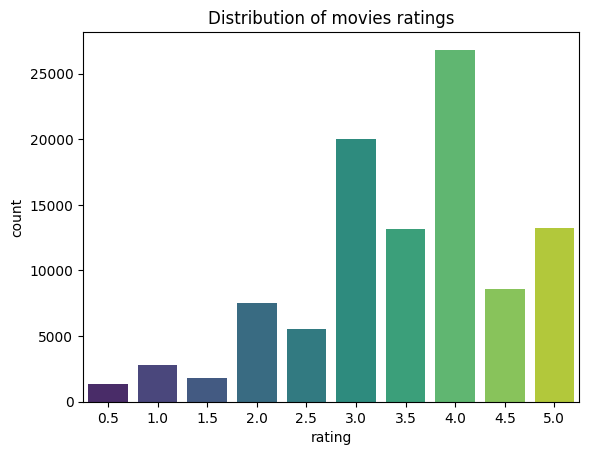

In [42]:
#Rozkład ocen
sns.countplot(x="rating", data = ratings, palette = "viridis")
plt.title('Distribution of movies ratings')
plt.show()

In [45]:
# Stwórz słowniki – zwracające tytuł filmu po jego id
movie_titles = dict(zip(movies['movieId'], movies['title']))

Bayesian Average - średnia beyesowska

In [56]:
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
  bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
  return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']

movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')
movie_stats.describe()

,movieId,count,mean,bayesian_avg
count,9724.000000,9724.000000,9724.000000,9724.000000
mean,42245.024373,10.369807,3.262448,3.285871
std,52191.137320,22.401005,0.869874,0.227598
min,1.000000,1.000000,0.500000,2.190377
25%,3245.500000,1.000000,2.800000,3.151413
50%,7300.000000,3.000000,3.416667,3.283341
75%,76739.250000,9.000000,3.911765,3.390547
max,193609.000000,329.000000,5.000000,4.392070


Przekształcenie danych - sparse matrix

In [71]:
def create_sparse(df):

  M = df['userId'].nunique()
  N = df['movieId'].nunique()

  user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
  movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
  user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
  movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
  user_index = [user_mapper[i] for i in df['userId']]
  item_index = [movie_mapper[i] for i in df['movieId']]

  X = csr_matrix((df["rating"], (user_index, item_index)), shape=(M,N))

  return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

Sparse matrix - rzadkość macierzy

In [72]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_sparse(ratings)

In [73]:
n_total = X.shape[0] * X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings / n_total
sparsity_p = round(sparsity * 100, 2)
print(f"Matrix sparsity: {sparsity_p}%")

n_ratings_per_user = X.getnnz(axis=1)


Matrix sparsity: 1.7%


Problem „zimnego startu” (cold start)

In [77]:
n_total = X.shape[0] * X.shape[1]
n_ratings = X.nnz  # scipy.sparse.csr_matrix.nnz liczba przechowywanych wartości, włączając jawną wartość 0
sparsity = n_ratings / n_total
sparsity_p = round(sparsity * 100, 2)
print(f"Matrix sparsity: {sparsity_p}%")

n_ratings_per_user = X.getnnz(axis=1)

Matrix sparsity: 1.7%


System rekomendacji - kNN


In [95]:
def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    X = X.T
    neighbour_ids = []
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
      movie_vec = movie_vec.reshape(1,-1)
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)

    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

Znajdź, 10 rekomendacji po obejrzeniu filmu: „Toy Story”

In [96]:
rekomendacje = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, 10)
rekomendacje

[3114, 480, 780, 260, 356, 364, 1210, 648, 1265]

In [100]:
print("Because you watched Toy Story")
for i in rekomendacje:
  print(movie_titles[i])

Because you watched Toy Story
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)
